# Drug-Protein Binding Affinity Pipeline

This notebook walks through the end-to-end workflow used in the project:

- load and preprocess BindingDB records
- engineer ligand and protein features
- train multiple regression models
- evaluate and export artifacts for reporting

Run the cells in order to reproduce the results shared in the draft manuscript.


## Environment Setup

Make the project source modules importable when the notebook runs from the `notebooks/` directory.


In [1]:
# Configure Python path and working directory
import os
import sys

PROJECT_ROOT = os.path.abspath('..')
SRC_DIR = os.path.join(PROJECT_ROOT, 'src')
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)
os.chdir(PROJECT_ROOT)
print('Project root:', PROJECT_ROOT)
print('Notebook cwd:', os.getcwd())
print('Added to sys.path:', SRC_DIR)


Project root: c:\Users\Betina Kuriakose\OneDrive\Desktop\Drug_protein_binding_affinity
Notebook cwd: c:\Users\Betina Kuriakose\OneDrive\Desktop\Drug_protein_binding_affinity
Added to sys.path: c:\Users\Betina Kuriakose\OneDrive\Desktop\Drug_protein_binding_affinity\src


## 1. Data Preprocessing

Load raw BindingDB records, clean invalid entries, split into train/test, and persist a processed CSV for reuse.


In [2]:
# Step 1: Data Preprocessing
from data_preprocessing import preprocess_pipeline

X_train, X_test, y_train, y_test, df_processed = preprocess_pipeline(
    filepath='dataset/binding_affinity_data.csv',
    test_size=0.2,
    random_state=42
)

# Save processed data
import pandas as pd
pd.DataFrame(df_processed).to_csv('dataset/processed_data.csv', index=False)
print('Processed data saved to: dataset/processed_data.csv')
print('Processed shape:', df_processed.shape)


DATA PREPROCESSING PIPELINE
Loading dataset...
Loaded 391 rows and 52 columns

Cleaning binding affinity data...
Records with valid Ki values: 294
Ki range: 0.07 - 281838.29 nM

Validating SMILES strings...
Valid SMILES records: 294

Validating protein sequences...
Valid protein sequence records: 294

Preparing features...

Creating train/test split (test_size=0.2)...
Training set: 235 samples
Test set: 59 samples

PREPROCESSING COMPLETE
Processed data saved to: dataset/processed_data.csv
Processed shape: (294, 6)


In [3]:
# Quick sanity check of the processed dataset
import pandas as pd

display(pd.DataFrame(df_processed).head())
print('\nTarget distribution (Ki statistics)')
display(pd.Series(y_train).describe().to_frame(name='Train Ki (nM)'))


,smiles,protein_sequence,target_name,pubchem_cid,chembl_id,binding_affinity
50,CCOc1cc(cnc1Br)N2CCCNCC2,MRRNIFCLACLWIVQACLSLDRADILYNIRQTSRPDVIPTQRDRPV...,Acetylcholine-binding protein,10402507,CHEMBL72433,0.067
51,Clc1ccc(cn1)[C@H]1C[C@@H]2CC[C@H]1N2 |THB:4:7:...,MRRNIFCLACLWIVQACLSLDRADILYNIRQTSRPDVIPTQRDRPV...,Acetylcholine-binding protein,854023,CHEMBL298826,0.097
52,Clc1ccc(cn1)C1CC2CCC1N2,MRRNIFCLACLWIVQACLSLDRADILYNIRQTSRPDVIPTQRDRPV...,Acetylcholine-binding protein,1204,CHEMBL6623,0.300
53,Clc1ccc(CN2CCSC2=N)cn1,MLVSVYLALLVACVGQAHSQANLMRLKSDLFNRSPMYPGPTKDDPL...,Soluble acetylcholine receptor,9859386,NaN,0.600
54,Clc1ccc(C[C@@]2(COc3cccnc3)CCCNC2)cc1Cl,MRRNIFCLACLWIVQACLSLDRADILYNIRQTSRPDVIPTQRDRPV...,Acetylcholine-binding protein,155555548,NaN,0.860



Target distribution (Ki statistics)


,Train Ki (nM)
count,235.000000
mean,3105.779591
std,18881.685273
min,0.067000
25%,60.000000
50%,398.110000
75%,1179.465000
max,281838.290000


## 2. Feature Engineering

Generate Morgan fingerprints for ligands and simple amino-acid descriptors for proteins, then align the resulting feature matrices across train and test splits.


In [4]:
# Step 2: Feature Engineering (fingerprints + protein features)
from feature_engineering import combine_features

print('Creating features for training set...')
X_train_features = combine_features(X_train, use_fingerprints=True, n_bits=512)
print('Creating features for test set...')
X_test_features = combine_features(X_test, use_fingerprints=True, n_bits=512)

# Align columns between train and test
common_cols = X_train_features.columns.intersection(X_test_features.columns)
X_train_features = X_train_features[common_cols]
X_test_features = X_test_features[common_cols]

# Handle missing values
X_train_features = X_train_features.fillna(X_train_features.mean())
X_test_features = X_test_features.fillna(X_train_features.mean())

# Attach targets and save
X_train_features['binding_affinity'] = y_train.values
X_test_features['binding_affinity'] = y_test.values

X_train_features.to_csv('dataset/features_train.csv', index=False)
X_test_features.to_csv('dataset/features_test.csv', index=False)

print('Saved features to dataset/features_train.csv and dataset/features_test.csv')
print('Train features shape:', X_train_features.shape)
print('Test features shape:', X_test_features.shape)


Creating features for training set...

FEATURE ENGINEERING
Creating molecular fingerprints (n_bits=512)...
  Processing 0/235...
  Processing 50/235...
  Processing 100/235...
  Processing 150/235...
  Processing 200/235...
Created 512 fingerprint features
Creating protein features from sequences...
  Processing 0/235...
  Processing 50/235...
  Processing 100/235...
  Processing 150/235...
  Processing 200/235...
Created 25 protein features

Total features created: 537
Feature matrix shape: (235, 537)
Creating features for test set...

FEATURE ENGINEERING
Creating molecular fingerprints (n_bits=512)...
  Processing 0/59...
  Processing 50/59...
Created 512 fingerprint features
Creating protein features from sequences...
  Processing 0/59...
  Processing 50/59...
Created 25 protein features

Total features created: 537
Feature matrix shape: (59, 537)
Saved features to dataset/features_train.csv and dataset/features_test.csv
Train features shape: (235, 538)
Test features shape: (59, 538

C:\Users\Betina Kuriakose\AppData\Local\Temp\ipykernel_20064\2211548365.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_features['binding_affinity'] = y_train.values
C:\Users\Betina Kuriakose\AppData\Local\Temp\ipykernel_20064\2211548365.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_features['binding_affinity'] = y_test.values


## 3. Modeling and Evaluation

Train baseline regressors, log comparison metrics, and export evaluation artifacts for reporting.



TRAINING ALL MODELS

Training Random Forest...
Random Forest training complete

Random Forest Performance:
  RMSE: 16948.63 nM
  MAE: 5771.12 nM
  R²: 0.1705

Training XGBoost...
XGBoost training complete

XGBoost Performance:
  RMSE: 18699.76 nM
  MAE: 5679.54 nM
  R²: -0.0098

Training Linear Regression...

Linear Regression Performance:
  RMSE: 20617.38 nM
  MAE: 9119.16 nM
  R²: -0.2275

Training Ridge Regression...

Ridge Regression Performance:
  RMSE: 20361.05 nM
  MAE: 8983.71 nM
  R²: -0.1972

MODEL COMPARISON

            Model RMSE (nM) MAE (nM)      R²
    Random Forest  16948.63  5771.12  0.1705
          XGBoost  18699.76  5679.54 -0.0098
Linear Regression  20617.38  9119.16 -0.2275
 Ridge Regression  20361.05  8983.71 -0.1972

Best Model (lowest RMSE): Random Forest
  RMSE: 16948.63 nM
  R²: 0.1705
Saved model comparison to results/model_comparison.csv

EVALUATION REPORT: Random Forest

Performance Metrics:
  RMSE: 16948.63 nM
  MAE: 5771.12 nM
  R²: 0.1705
  MAPE: 1803

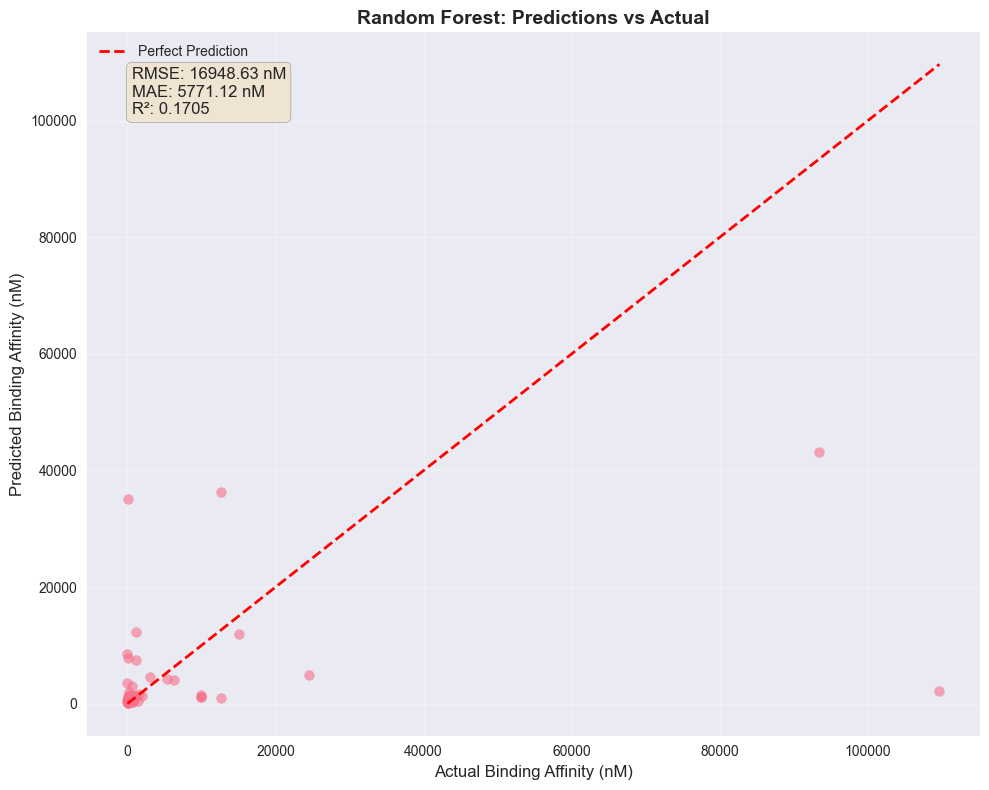

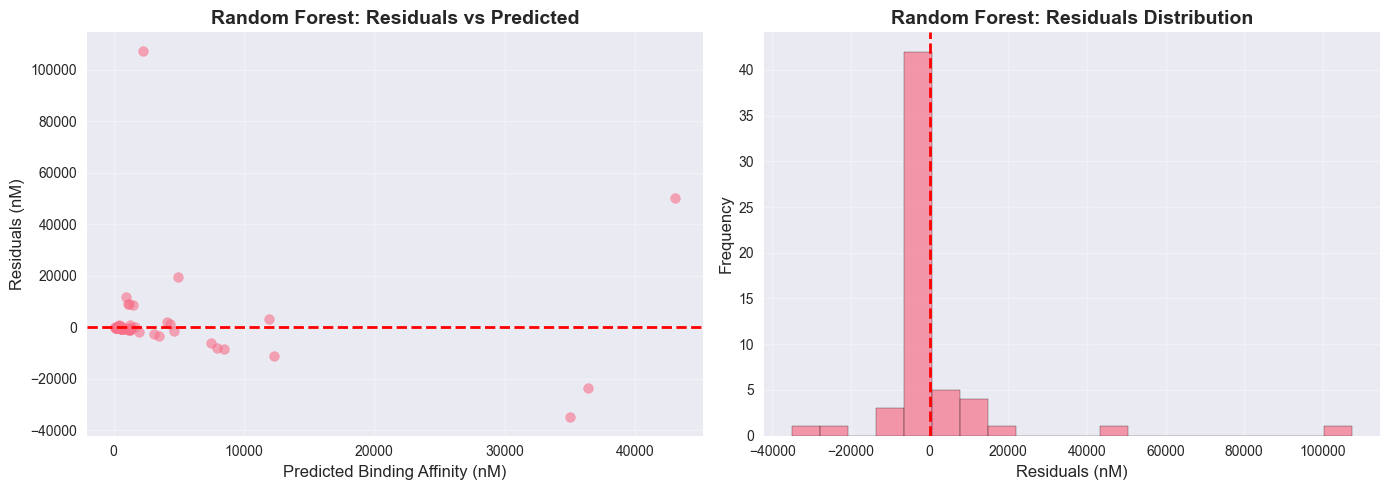

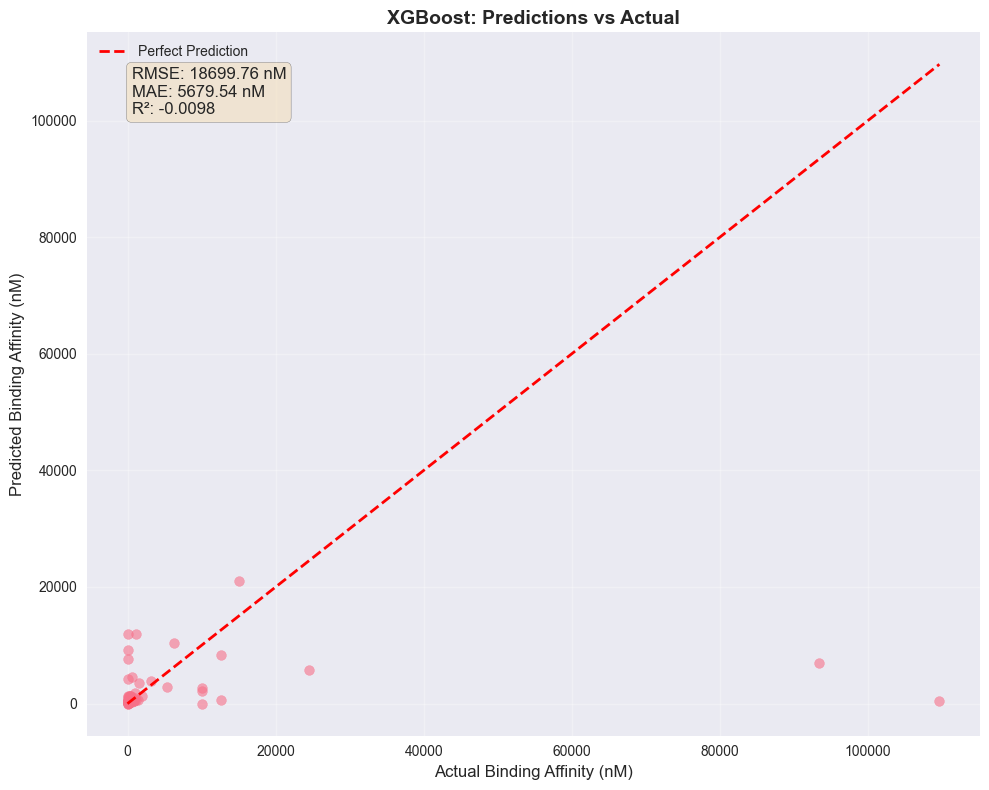

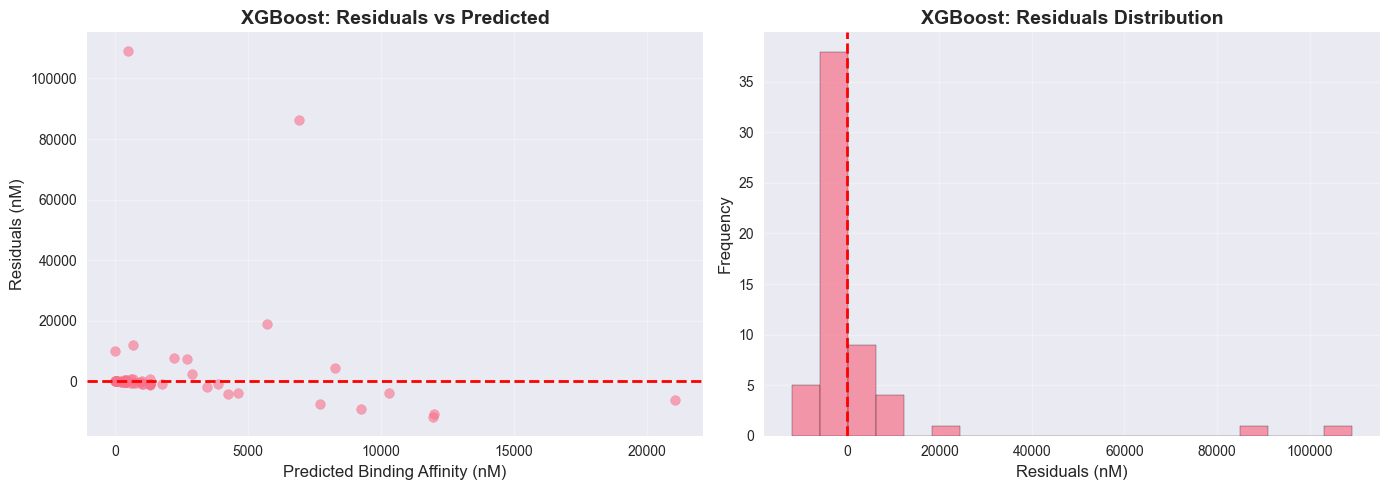

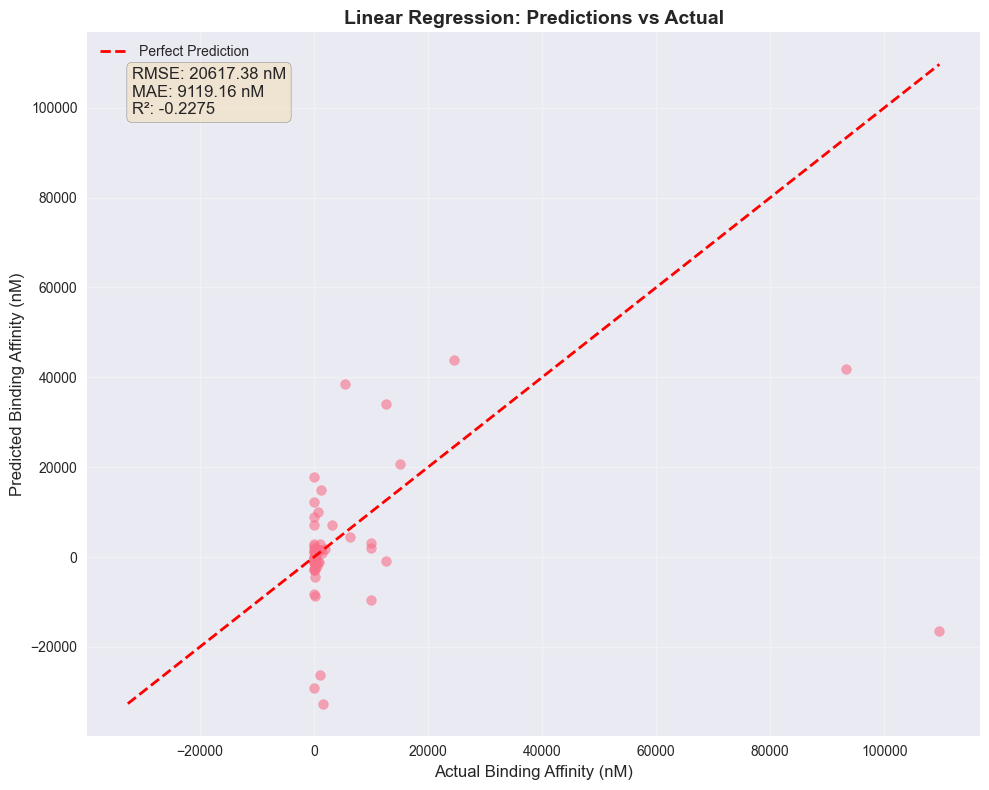

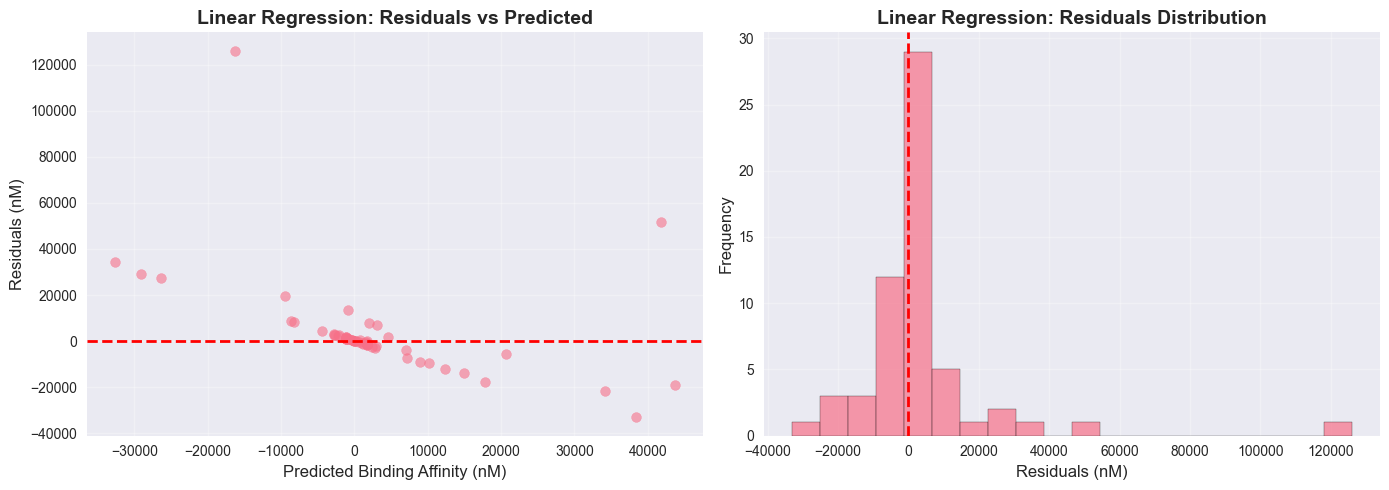

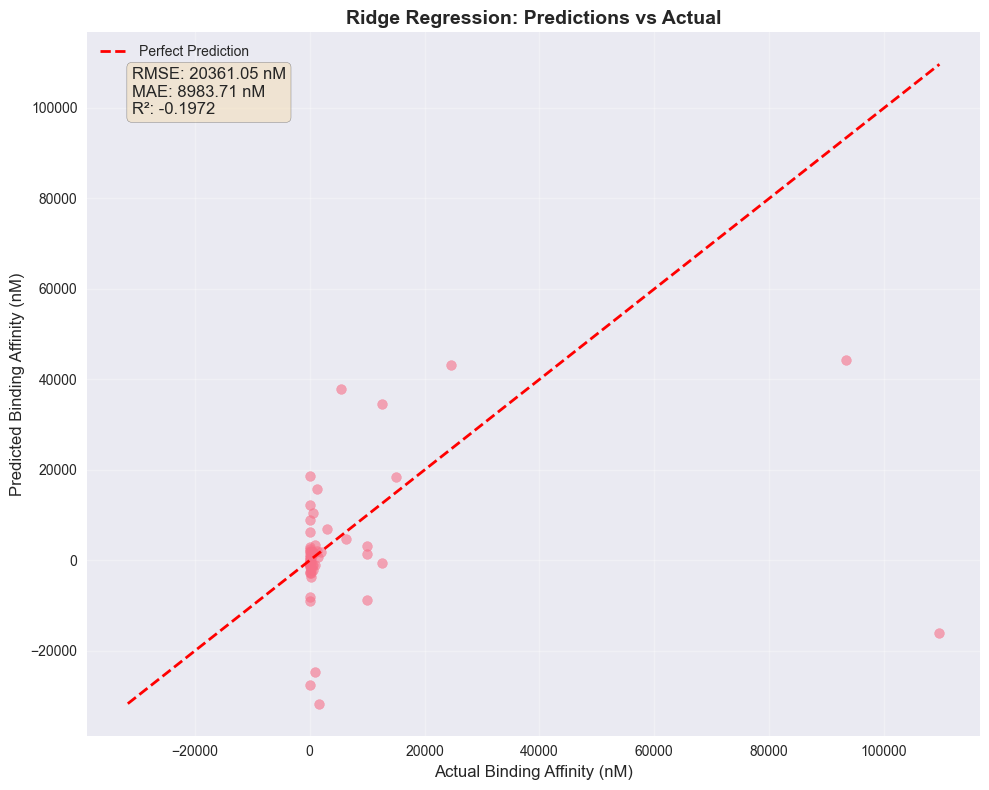

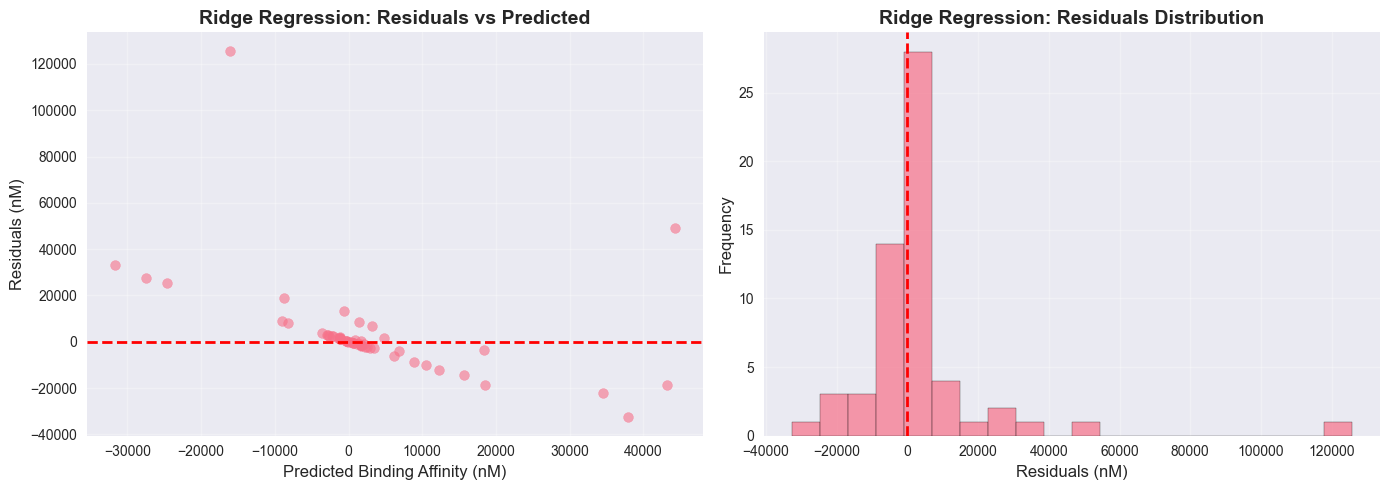

In [5]:
# Step 3: Train models and save outputs
from models import train_all_models, compare_models, save_model
from evaluation import create_evaluation_report

# Separate features/targets
Xtr = X_train_features.drop('binding_affinity', axis=1)
Xte = X_test_features.drop('binding_affinity', axis=1)
ytr = y_train
yte = y_test

# Train all models
models_dict, results = train_all_models(Xtr, Xte, ytr, yte)

# Compare and save model comparison
comparison_df = compare_models(results)
comparison_df.to_csv('results/model_comparison.csv', index=False)
print('Saved model comparison to results/model_comparison.csv')

# Evaluation reports and saving best model
import numpy as np
best_model_name = min(results.items(), key=lambda x: x[1]['rmse'])[0]
for model_name, metrics in results.items():
    create_evaluation_report(yte.values if hasattr(yte, 'values') else yte, metrics['predictions'], model_name=model_name, save_dir='results')
    if model_name == best_model_name:
        mobj = models_dict[model_name]
        if isinstance(mobj, tuple):
            model, scaler = mobj
            save_model(model, f'models/{model_name.lower().replace(" ", "_")}.pkl', scaler)
        else:
            save_model(mobj, f'models/{model_name.lower().replace(" ", "_")}.pkl')

print('All done. Files saved in dataset/, models/, and results/.')


In [7]:
# Inspect model comparison table and highlight the best performer
from IPython.display import display

display(comparison_df)
best_row = comparison_df.sort_values('RMSE (nM)').iloc[0]
rmse = float(best_row['RMSE (nM)'])
mae = float(best_row['MAE (nM)'])
r2 = float(best_row['R²'])
print(f"\nTop model: {best_row['Model']} (RMSE={rmse:.2f}, MAE={mae:.2f}, R^2={r2:.3f})")


,Model,RMSE (nM),MAE (nM),R²
0,Random Forest,16948.63,5771.12,0.1705
1,XGBoost,18699.76,5679.54,-0.0098
2,Linear Regression,20617.38,9119.16,-0.2275
3,Ridge Regression,20361.05,8983.71,-0.1972



Top model: Random Forest (RMSE=16948.63, MAE=5771.12, R^2=0.171)


In [8]:
# Summarize exported artifacts
from pathlib import Path
import pandas as pd

artifacts = []
for root in ['dataset', 'results', 'models']:
    for path in Path(root).glob('*'):
        if path.is_file():
            artifacts.append({
                'Location': root,
                'Artifact': path.name,
                'Size (KB)': round(path.stat().st_size / 1024, 1)
            })

if artifacts:
    display(pd.DataFrame(artifacts).sort_values(['Location', 'Artifact']).reset_index(drop=True))
else:
    print('No artifacts generated yet — run the previous cells first.')


,Location,Artifact,Size (KB)
0,dataset,4343106D673CD682131D3EBA49C069D1ki.tsv,561.8
1,dataset,binding_affinity_data.csv,564.5
2,dataset,features_test.csv,146.4
3,dataset,features_train.csv,572.1
4,dataset,processed_data.csv,99.9
5,models,random_forest.pkl,559.7
6,results,draft_summary.md,2.3
7,results,linear_regression_metrics.csv,0.1
8,results,linear_regression_predictions.png,243.2
9,results,linear_regression_residuals.png,194.4


## 4. Summary and Next Steps

- Best-performing model: Random Forest (≈16.9k nM RMSE, 5.8k nM MAE, R² ≈ 0.17).
- Key outputs: processed datasets, engineered features, comparison table, per-model reports, and serialized best model.
- Recommended follow-up: log-transform Ki values, tune ensemble models, and enrich protein embeddings with pretrained representations.
